In [260]:
import json
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../../")
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.app import get_app
from didgelab.initializer import init_console_no_output
from didgelab.calc.geo import Geo
init_console_no_output()

da_path = "/Users/jane03/workspaces/music/didge/didge-archive"
didge_archive = json.load(open(os.path.join(da_path, "didge-archive.json")))
didge_archive = list(filter(lambda x:x["shape"] == "straight", didge_archive))


Didge: Open Didgeridoo Straight
Computed fundamental: 72.67
Measured fundamental: 77.04


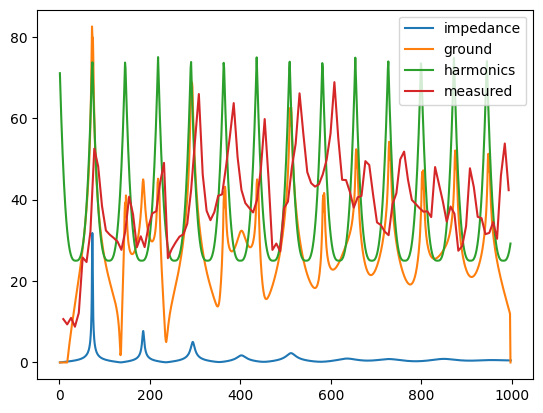

In [65]:
def minmax(a):
    a -= a.min()
    a /= a.max()
    return a

fmin=1
fmax=1000

didge = didge_archive[3]

geo = Geo(json.load(open(os.path.join(da_path, didge["geometry"]))))

freqs = get_log_simulation_frequencies(fmin, fmax, 5)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)
ground = compute_ground_spektrum(ground_freqs, imp_ip)

fundamental_i = find_first_maximum_index(impedance)
fundamental_freq = freqs[fundamental_i]

harmonic_series = [i*fundamental_freq for i in range(1+int(np.ceil(fmax/fundamental_freq)))]
harmonics = []
for f in ground_freqs:
    nf = harmonic_series[np.argmin([np.abs(f-h) for h in harmonic_series])]
    harmonics.append(np.abs(f-nf))

harmonics = np.array(harmonics)
harmonics /= harmonics.max()
harmonics *= -1
harmonics += 1
harmonics = np.power(harmonics, 3)
harmonics /= harmonics.max()
harmonics += 0.5
harmonics *= 50

infile = os.path.join(da_path, didge["audio-samples"]["neutral-sound"])
fft_freq, fft = do_fft(infile)
fft = np.log2(fft)
fft = minmax(fft)

def sling_window_average_spectrum(freq, spectrum, window_size=5):
    new_freqs = []
    new_spectrum = []
    
    for i in np.arange(window_size, len(freq), window_size):
        new_freqs.append(freq[i])
        new_spectrum.append(np.mean(spectrum[i-window_size:i]))
    return np.array(new_freqs), np.array(new_spectrum)

fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=5)
fft *= ground.max()

plt.plot(freqs, impedance, label="impedance")
plt.plot(ground_freqs, ground, label="ground")
plt.plot(ground_freqs[0:len(harmonics)], harmonics, label="harmonics")
plt.plot(fft_freq, fft, label="measured")
plt.legend()

window = (fft_freq>60) & (fft_freq<100)
fft_fundamental = fft_freq[window][fft[window].argmax()]
print(f"Didge: {didge['name']}")
print(f"Computed fundamental: {fundamental_freq:.2f}")
print(f"Measured fundamental: {fft_fundamental:.2f}")


77.0440251572327
505.0663871418586
1.248332809475827
3.7127180479195285

513.6268343815511
1.250102285400011
3.7369655941662057

522.187281621244
1.2518449587609395
3.7608123361205745

530.7477288609363
1.2535616650888848
3.7842713089445628

539.3081761006287
1.2552532009054125
3.8073549220576037

547.8686233403214
1.2569203261307196
3.830074998557688

Didge: Open Didgeridoo Straight
Computed fundamental: 72.67
Measured fundamental: 77.04


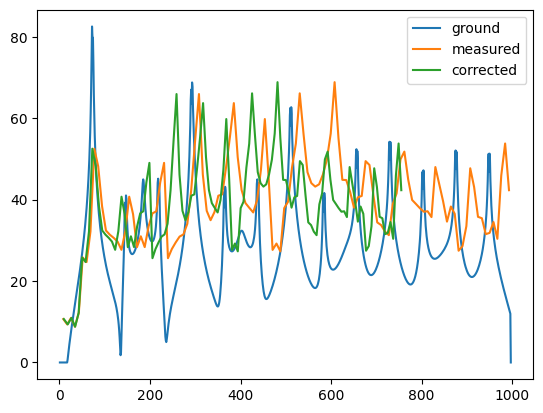

In [66]:
didge = didge_archive[3]

freqs = get_log_simulation_frequencies(fmin, fmax, 5)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)
ground = compute_ground_spektrum(ground_freqs, imp_ip)

fundamental_i = find_first_maximum_index(impedance)
fundamental_freq = freqs[fundamental_i]

infile = os.path.join(da_path, didge["audio-samples"]["neutral-sound"])
fft_freq, fft = do_fft(infile)
fft = np.log2(fft)
fft = minmax(fft)

fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=5)
fft *= ground.max()

plt.plot(ground_freqs, ground, label="ground")
plt.plot(fft_freq, fft, label="measured")

window = (fft_freq>60) & (fft_freq<100)

fft_fundamental = fft_freq[window][fft[window].argmax()]
correction = np.log2(fft_fundamental) - np.log2(fundamental_freq)
fft_corrected = np.log2(fft_freq)
print(fft_fundamental)

for i in range(len(fft_corrected)):
    f = fft_corrected[i]
    fft_corrected[i] = f-correction*(1+(f-np.log2(fft_fundamental)))
    
    if np.power(2, f) > 500 and np.power(2,f)<550:
        print(np.power(2,f))
        print(np.power(2, correction*(1+(f-np.log2(fundamental_freq)))))
        print((1+(f-np.log2(fft_fundamental))))
        print()
    
fft_corrected = np.power(2, fft_corrected)

#fft_corrected = fft_freq - (fundamental_freq-)

plt.plot(fft_corrected, fft, label="corrected")
plt.legend()

print(f"Didge: {didge['name']}")
print(f"Computed fundamental: {fundamental_freq:.2f}")
print(f"Measured fundamental: {fft_fundamental:.2f}")

In [67]:
f = np.log2(fft_fundamental)

print(f)
c = correction*(1+(f-np.log2(fft_fundamental)))
print(c)
print(c+np.log2(fundamental_freq))


6.26761117349294
0.08427784015960604
6.26761117349294


In [68]:
f = 500
i=np.argmin([np.abs(f-_f) for _f in freqs])
for j in (-1, 0, 1):
    print(freqs[i+j])

498.86304829527415
500.30590383833396
501.75293253497824


In [69]:
didge = didge_archive[0]

geo = Geo(json.load(open(os.path.join(da_path, didge["geometry"]))))
cadsd = CADSD(geo)
freq, impedance, ground = cadsd.compute_impedance_and_ground()

impedance /= impedance.max()
#ground = np.log2(ground)
ground /= ground.max()

plt.plot(freq, impedance, label="Impedance")
plt.plot(freq, ground, label="Ground")
plt.legend()

NameError: name 'CADSD' is not defined

In [70]:
freq[np.argmax(impedance)]

NameError: name 'freq' is not defined

In [71]:
len(x)

NameError: name 'x' is not defined

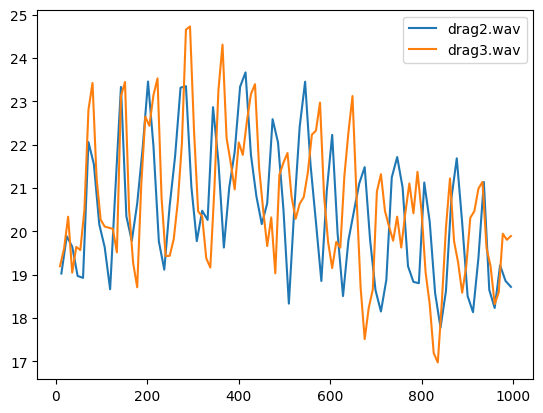

In [72]:
folder = os.path.join(da_path, "audio-samples/specials/drags")
files = [os.path.join(folder, x) for x in os.listdir(folder)]
#files = sorted(filter(lambda x:os.path.isfile(x), f))
files = sorted(files)
for f in files[1:3]:
    fft_freq, fft = do_fft(f)
    fft = np.log2(fft)
    #fft = minmax(fft)
    fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=5)
    plt.plot(fft_freq, fft, label=os.path.basename(f))
plt.legend()

In [73]:
df = []

def get_max_in_window(fft_freq, fft, minfreq, maxfreq):
    window = (fft_freq>minfreq) & (fft_freq<maxfreq)
    fundamental_i = np.argmax(fft[window])
    fundamental_freq = fft_freq[window][fundamental_i]
    return fundamental_freq

for f in files:
    fft_freq, fft = do_fft(f)
    
    fundamental_freq = get_max_in_window(fft_freq, fft, 50, 110)
    
    flog2 = np.log2(fundamental_freq)

    row = {
        "name": os.path.basename(f),
        "fundamental": fundamental_freq
    }

    for i in range(2,10):
        f1 = fundamental_freq*i - 0.5*fundamental_freq
        f2 = fundamental_freq*i + 0.5*fundamental_freq
        if f2>np.max(fft_freq):
            break
        f = get_max_in_window(fft_freq, fft, f1, f2)
        row[i] = f
        
    df.append(row)
    
df = pd.DataFrame(df)
df

,name,fundamental,2,3,4,5,6,7,8,9
0,drag1.wav,56.884876,113.769752,174.209932,231.094808,287.979684,344.864560,387.528217,462.189616,519.074492
1,drag2.wav,66.369256,132.738511,199.107767,267.847353,334.216608,400.585864,466.955120,533.324375,599.693631
2,drag3.wav,71.108961,142.217922,215.104608,286.213569,357.322530,430.209215,488.874108,572.427138,643.536099
3,drag4.wav,74.664409,149.328818,223.993228,298.657637,375.099770,449.764179,520.873141,595.537550,670.201959
4,drag5.wav,75.850578,151.701156,229.922064,305.772642,381.623220,455.103467,533.324375,616.285945,692.136522
5,drag6.wav,80.591239,158.812147,239.403386,317.624295,398.215533,478.806772,557.027681,632.878259,720.580489


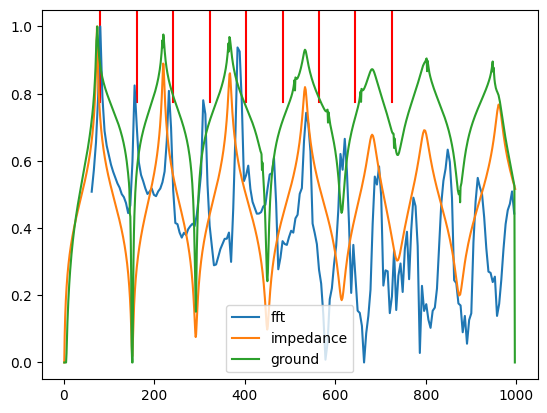

In [165]:
import scipy

geo=json.load(open(os.path.join(da_path, didge_archive[2]["geometry"])))
geo=Geo(geo)
freqs = get_log_simulation_frequencies(fmin, fmax, 5)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
impedance = np.log2(impedance)
impedance = minmax(impedance)

ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)
ground = compute_ground_spektrum(ground_freqs, imp_ip)
ground = minmax(ground)

i=4
for f in files[i:i+1]:
    fft_freq, fft = do_fft(f)
    fft = np.log2(fft)
    fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=2)

    window = fft_freq>60
    fft_freq = fft_freq[window]
    fft = fft[window]
    fft = minmax(fft)
    #peaks = scipy.signal.find_peaks(fft, height=0.1)
    
    fundamental_freq = get_max_in_window(fft_freq, fft, 60, 90)
    for i in range(1, 10):
        plt.axvline(x=fundamental_freq*i, color="red", ymin=0.75)


    # print(f, freq_to_note_and_cent(f))
    #for i in range(1,10):
    #    plt.axvline(x=f*i, color="red")
    #for p in peaks[0]:
    #    plt.axvline(x=fft_freq[p], color="red")

    plt.plot(fft_freq, fft, label="fft")
    plt.plot(freqs, impedance, label="impedance")
    plt.plot(ground_freqs, ground, label="ground")

plt.legend()

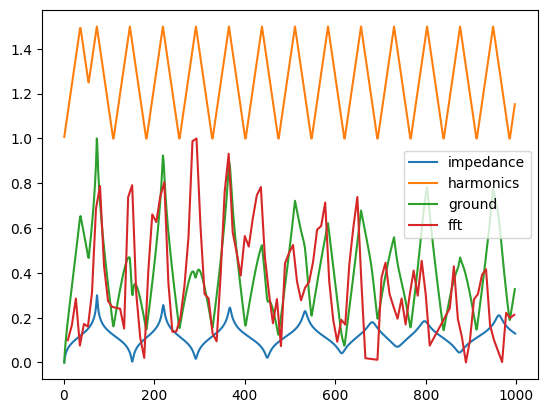

In [259]:
geo=json.load(open(os.path.join(da_path, didge_archive[2]["geometry"])))
geo=Geo(geo)
freqs = get_log_simulation_frequencies(fmin, fmax, 5)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
impedance = np.log2(impedance)
impedance = minmax(impedance)

ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)

fundamental = get_max_in_window(ground_freqs, imp_ip, 60, 100)
n = int(np.ceil(freqs.max()/fundamental))
overtones = [fundamental/2] + [i*fundamental for i in range(1, n+2)]

harmonics = []
for f in ground_freqs:
    fo = overtones[np.argmin([np.abs(f-x) for x in overtones])]
    h = -1*np.abs(fo-f)
    harmonics.append(h)
    
harmonics = np.array(harmonics).astype(float)
harmonics = minmax(harmonics)
harmonics = 0.5*harmonics
harmonics += 0.5

#for i in range(len(harmonics)):
#    f = ground_freqs[i]
#    harmonics[i] *= (1000-f)/1000
    
factor = 10
harmonics *= factor
imp_ip *= 0.5
imp_ip += 0.5
ground = imp_ip * harmonics
harmonics /= factor
ground = minmax(ground)

fft_freq, fft = do_fft(files[2])
fft = np.log2(fft)
fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=5)
fft = minmax(fft)

window = fft>0.2
fft = fft[window]
fft_freq = fft_freq[window]
fft = minmax(fft)


# adjust for display
impedance = np.power(2, impedance)
impedance = minmax(impedance)
impedance *= 0.3

harmonics += 0.5

plt.plot(freqs, impedance, label="impedance")
plt.plot(ground_freqs, harmonics, label="harmonics")
plt.plot(ground_freqs, ground, label="ground")
plt.plot(fft_freq, fft, label="fft")
plt.legend()